### Importing Packages

In [1]:
from model import GeneratorGAN, DiscriminatorGAN
from train import trainDiscriminator, trainGenerator
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.autograd.variable import Variable
import torchvision.utils as vutils
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.animation as animation
from IPython.display import HTML
import pickle as pkl

### Initializing GPU

In [2]:
print(f'CUDA available: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CUDA available: True


In [3]:
root = 'seg_train'
dataset = dset.ImageFolder(root=root,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                           ]))
'''images = []
labels = []

for image, label in dataset:
    if image.shape == (3, 64, 64):
        images.append(image)
        labels.append(label)

images_tensor = torch.stack(images)  
labels_tensor = torch.tensor(labels)


dataset = TensorDataset(images_tensor, labels_tensor)'''

train_size = int(.7 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size] )
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=2, drop_last = True)

### Weight Initialization

In [4]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### Initializing and Debugging Generator Model

In [5]:
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
fixed_noise = torch.rand(128, 100, 1, 1)
fixed_noise = fixed_noise.to(device)
with torch.no_grad():
    output = G(fixed_noise)
output.shape

torch.Size([128, 3, 64, 64])

### Initializing and Debugging Discriminator Model

In [6]:
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
sample_image = dataset[0][0]
sample_image = sample_image.unsqueeze(0)
sample_image = sample_image.to(device)
with torch.no_grad():
    output = D(sample_image)
output.shape

torch.Size([1, 1, 1, 1])

### Optimizing Number of Epochs

In [ ]:
num_epochs = [10, 50, 100]
lr = .0002
for epoch_num in num_epochs:
    dLoss = []
    gLoss = []
    G = GeneratorGAN(kernSize = 5, padVal = 2)
    G = G.to(device)   
    G.apply(w_init)
    D = DiscriminatorGAN(kernSize = 5, padVal = 2)
    D = D.to(device)
    D.apply(w_init)
    optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
    optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))       

    for epoch in range(epoch_num):
        for i, (images, _) in enumerate(train_loader):
            dError  = trainDiscriminator(D, G, optimD, images, 128, device)
            gError = trainGenerator(D, G, optimG, images, 128, device)
        dLoss.append(dError.cpu().tolist())
        gLoss.append(gError.cpu().tolist())

    torch.save(G, f'G_{epoch_num}.pt')
    torch.save(D, f'D_{epoch_num}.pt')

    print(f'After {epoch_num} epochs: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
    fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
    fake_images = vutils.make_grid(fake_images, padding = True)
    plt.figure()
    plt.plot(dLoss, label = "Discriminator")
    plt.plot(gLoss, label = "Generator")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Discriminator and Generator Loss Over Epochs")

    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title(f"Fake Images After {epoch_num} Epochs")
    plt.imshow(np.transpose(fake_images,(1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs: 	Discriminator Loss: 0.2846354842185974	 Generator Loss: 3.605065107345581



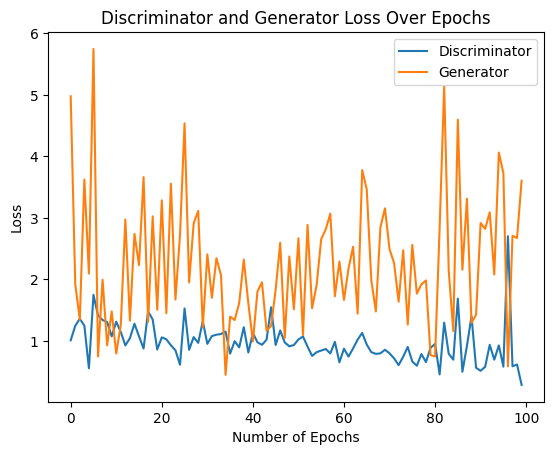

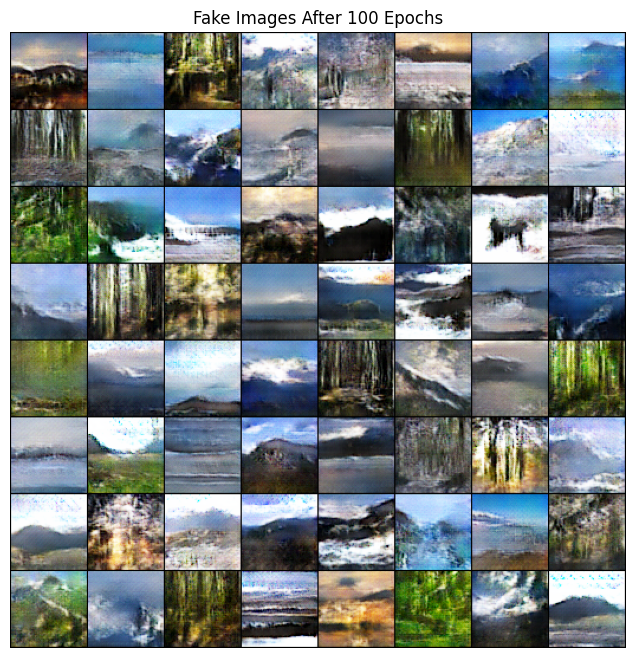

In [11]:
epoch_num = 100
lr = .0002
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))   
for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError  = trainDiscriminator(D, G, optimD, images, 128, device)
        gError = trainGenerator(D, G, optimG, images, 128, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}.pt')
torch.save(D, f'D_{epoch_num}.pt')

print(f'After {epoch_num} epochs: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Discriminator and Generator Loss Over Epochs")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

In [15]:
epoch_num = 200
lr = .00009
batch_size = 128
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))   
for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, batch_size, device)
        gError = trainGenerator(D, G, optimG, images, batch_size, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}_{7-3}.pt')
torch.save(D, f'D_{epoch_num}_{lr}_{7-3}.pt')
print(f'After {epoch_num} epochs with kernel size = 7 and padding = 3: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title(f"Discriminator and Generator Loss Over Epochs Using Kernel Size = 7 and Padding = 3")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

In [ ]:
epoch_num = 300
lr = .00009
batch_size = 128
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))   
for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, batch_size, device)
        gError = trainGenerator(D, G, optimG, images, batch_size, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}_{7-3}.pt')
torch.save(D, f'D_{epoch_num}_{lr}_{7-3}.pt')
print(f'After {epoch_num} epochs with kernel size = 7 and padding = 3: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title(f"Discriminator and Generator Loss Over Epochs Using Kernel Size = 7 and Padding = 3")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

### Optimizing Learning Rate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs with learning rate = 0.0006: 	Discriminator Loss: 100.0	 Generator Loss: 0.0



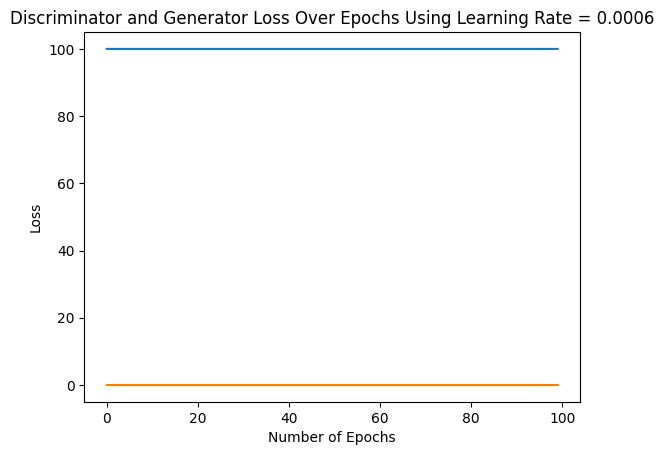

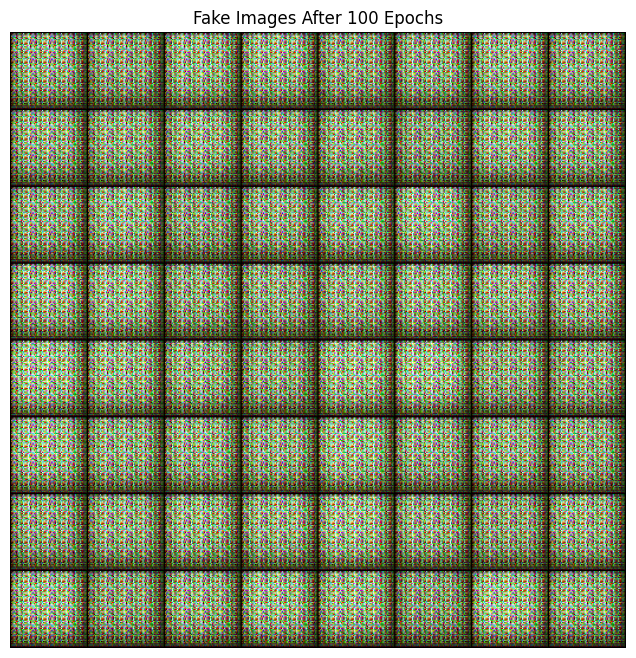

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs with learning rate = 0.0009: 	Discriminator Loss: 100.0	 Generator Loss: 0.0



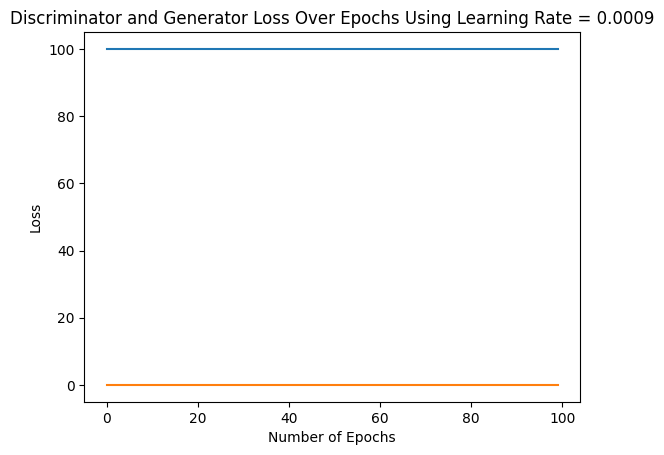

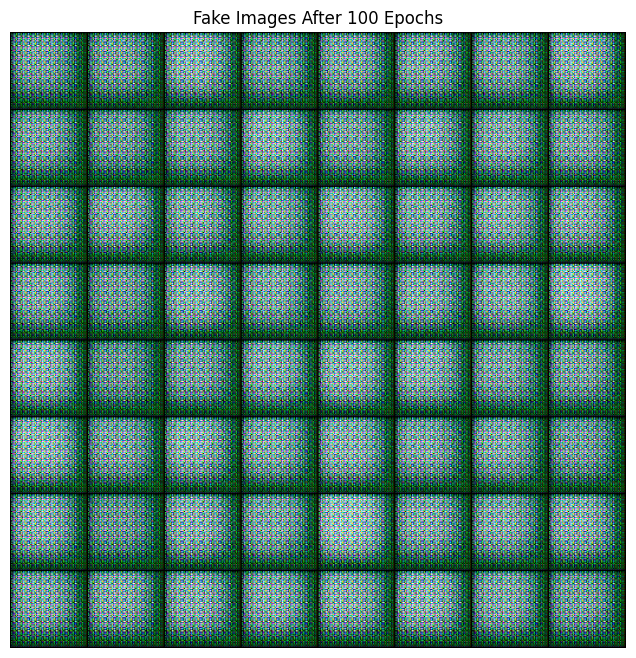

KeyboardInterrupt: 

In [10]:
epoch_num = 100 
learning_rates = [.00009, .0006, .0009]
for lr in learning_rates:
    dLoss = []
    gLoss = []
    G = GeneratorGAN(kernSize = 5, padVal = 2)
    G = G.to(device)   
    G.apply(w_init)
    D = DiscriminatorGAN(kernSize = 5, padVal = 2)
    D = D.to(device)
    D.apply(w_init)
    optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
    optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))       
    
    for epoch in range(epoch_num):
        for i, (images, _) in enumerate(train_loader):
            dError = trainDiscriminator(D, G, optimD, images, 128, device)
            gError = trainGenerator(D, G, optimG, images, 128, device)
        dLoss.append(dError.cpu().tolist())
        gLoss.append(gError.cpu().tolist())

    torch.save(G, f'G_{epoch_num}_{lr}.pt')
    torch.save(D, f'D_{epoch_num}_{lr}.pt')
    print(f'After {epoch_num} epochs with learning rate = {lr}: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
    fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
    fake_images = vutils.make_grid(fake_images, padding = True)
    plt.figure()
    plt.plot(dLoss, label = "Discriminator")
    plt.plot(gLoss, label = "Generator")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.title(f"Discriminator and Generator Loss Over Epochs Using Learning Rate = {lr}")

    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title(f"Fake Images After {epoch_num} Epochs")
    plt.imshow(np.transpose(fake_images,(1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs with learning rate = 9e-05: 	Discriminator Loss: 0.6385765671730042	 Generator Loss: 1.2651441097259521



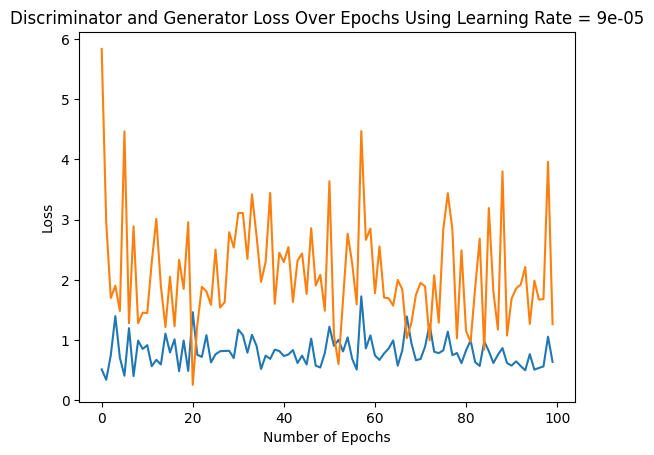

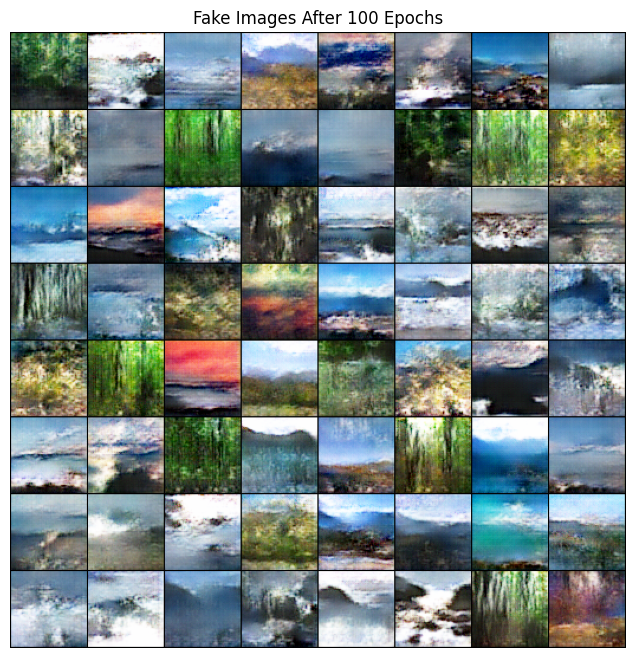

In [15]:
lr = .00009
epoch_num = 100
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))       

for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, 128, device)
        gError = trainGenerator(D, G, optimG, images, 128, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}.pt')
torch.save(D, f'D_{epoch_num}_{lr}.pt')
print(f'After {epoch_num} epochs with learning rate = {lr}: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title(f"Discriminator and Generator Loss Over Epochs Using Learning Rate = {lr}")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

### Optimizing BatchSize

In [ ]:
epoch_num = 100
lr = .0000
batch_size = 64
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 5, padVal = 2)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 5, padVal = 2)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))       

for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, batch_size, device)
        gError = trainGenerator(D, G, optimG, images, batch_size, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}.pt')
torch.save(D, f'D_{epoch_num}_{lr}.pt')
print(f'After {epoch_num} epochs with batch size = {batch_size}: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title(f"Discriminator and Generator Loss Over Epochs Using Batch Size = {batch_size}")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

### Trying a Smaller Kernel Size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs with kernel size = 3 and padding = 1: 	Discriminator Loss: 0.695588231086731	 Generator Loss: 3.3637771606445312



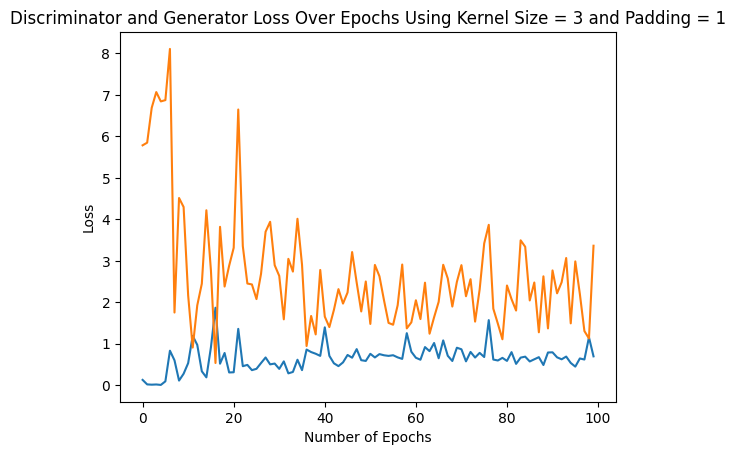

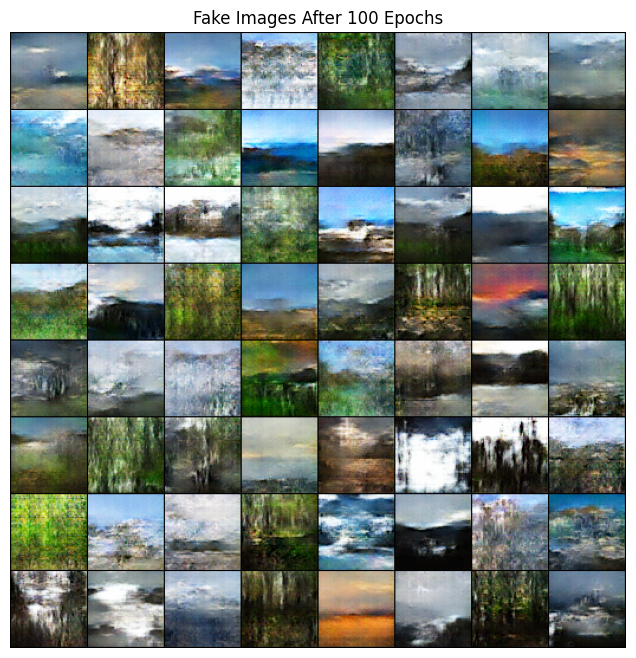

In [12]:
epoch_num = 100
lr = .00009
batch_size = 128
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 3, padVal = 1)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 3, padVal = 1)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))   

for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, batch_size, device)
        gError = trainGenerator(D, G, optimG, images, batch_size, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}_3-1.pt')
torch.save(D, f'D_{epoch_num}_{lr}_3-1.pt')
print(f'After {epoch_num} epochs with kernel size = 3 and padding = 1: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss Over Epochs Using Kernel Size = 3 and Padding = 1")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

### Trying a Larger Kernel Size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After 100 epochs with kernel size = 7 and padding = 3: 	Discriminator Loss: 1.1416351795196533	 Generator Loss: 0.8996396660804749



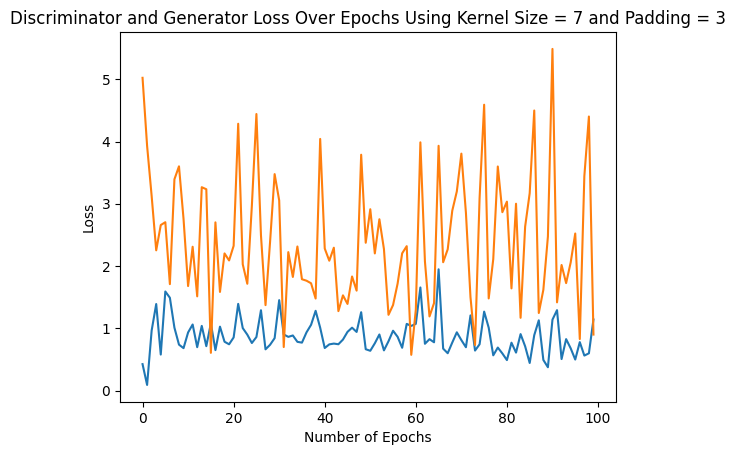

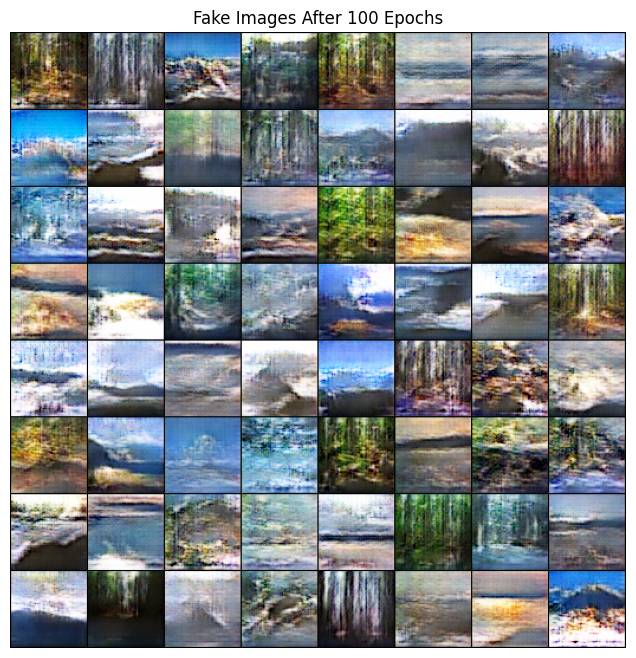

In [14]:
epoch_num = 100
lr = .00009
batch_size = 128
dLoss = []
gLoss = []
G = GeneratorGAN(kernSize = 7, padVal = 3)
G = G.to(device)   
G.apply(w_init)
D = DiscriminatorGAN(kernSize = 7, padVal = 3)
D = D.to(device)
D.apply(w_init)
optimD = optim.Adam(D.parameters(), lr = lr, betas = (0.5, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (0.5, .999))   
for epoch in range(epoch_num):
    for i, (images, _) in enumerate(train_loader):
        dError = trainDiscriminator(D, G, optimD, images, batch_size, device)
        gError = trainGenerator(D, G, optimG, images, batch_size, device)
    dLoss.append(dError.cpu().tolist())
    gLoss.append(gError.cpu().tolist())

torch.save(G, f'G_{epoch_num}_{lr}_7-3.pt')
torch.save(D, f'D_{epoch_num}_{lr}_7-3.pt')
print(f'After {epoch_num} epochs with kernel size = 7 and padding = 3: \tDiscriminator Loss: {dError}\t Generator Loss: {gError}\n')
fake_images = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
fake_images = vutils.make_grid(fake_images, padding = True)
plt.figure()
plt.plot(dLoss, label = "Discriminator")
plt.plot(gLoss, label = "Generator")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title(f"Discriminator and Generator Loss Over Epochs Using Kernel Size = 7 and Padding = 3")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title(f"Fake Images After {epoch_num} Epochs")
plt.imshow(np.transpose(fake_images,(1,2,0)))
plt.show()

### Testing

In [ ]:
genModel = GeneratorGAN()
discrimModel = DiscriminatorGAN()
genModel.load_state_dict(torch.load('.pt'))
discrimModel.load_state_dict(torch.load('.pt'))

correct = 0
images = genModel(torch.randn(100, 100, 1, 1))
fakes = discrimModel(images)
images = G(images.to(device))
real = discrimModel(images)